In [1]:
import numpy as np
import pandas as pd
import rasterio as rio
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
allFeatures = ['state', 'latitude', 'longitude', 'LS_VOLUME','slope', 'precip', 'ndvi', 'ndwi', 'elevation', 'snowcover', 'landcover', 'aspect', 'soil']
features = allFeatures[4:]
data = pd.read_csv('landslidesData.csv')[allFeatures]

In [4]:
data

,state,latitude,longitude,LS_VOLUME,slope,precip,ndvi,ndwi,elevation,snowcover,landcover,aspect,soil
0,UT: Jammu and Kashmir,34.440000,74.650000,0.0,2.642846,1.559059,0.243428,0.236140,1648,1.255170,40,238.261551,7
1,UT: Jammu and Kashmir,34.460000,74.650000,0.0,0.562423,1.557420,0.229066,0.250868,1726,0.853156,40,270.000000,7
2,UT: Jammu and Kashmir,34.440000,74.660000,0.0,32.345909,1.583275,0.180377,0.359278,1844,2.555970,111,262.657196,7
3,UT: Jammu and Kashmir,34.450000,74.660000,0.0,3.930439,1.583275,0.216668,0.271935,1689,1.465388,40,270.000000,7
4,UT: Jammu and Kashmir,34.320000,74.670000,0.0,0.000000,1.667750,0.141377,0.271801,1576,3.268761,40,0.000000,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17793,Uttarakhand,30.782778,77.839556,1200.0,28.192625,4.698819,0.208748,0.306490,1932,0.702693,111,20.580160,4
17794,Uttarakhand,30.784250,77.857028,1750.0,40.081722,4.632662,0.189584,0.269528,1683,0.546450,111,321.174591,7
17795,Uttarakhand,30.788359,77.870369,120000.0,35.500069,4.632662,0.197600,0.140747,1539,0.225511,20,228.842102,7
17796,Uttarakhand,30.793466,77.860249,8000.0,34.847729,4.632662,0.277588,0.154196,1427,0.134142,20,240.008560,7


In [5]:
# Read all rasters
bands = [f for f in features]
all_bands = {}
for band in bands:
    all_bands[band] = rio.open('updatedRasters/'+ band +'.tif').read()[0]
    image = all_bands[band]
    image = image.astype(float)
    image[image <= -1] = np.nan
    all_bands[band] = image
    
# Convert no data values to NaN in elevation, ndvi, soil bands
elevation = all_bands['elevation'].astype(float)
soil = all_bands['soil'].astype(float)
ndvi = all_bands['ndvi'].astype(float)
elevation[elevation ==0] = np.nan
ndvi[ndvi ==0] = np.nan
soil[soil == 255] = np.nan
all_bands['elevation'] = elevation
all_bands['soil'] = soil
all_bands['ndvi'] = ndvi

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

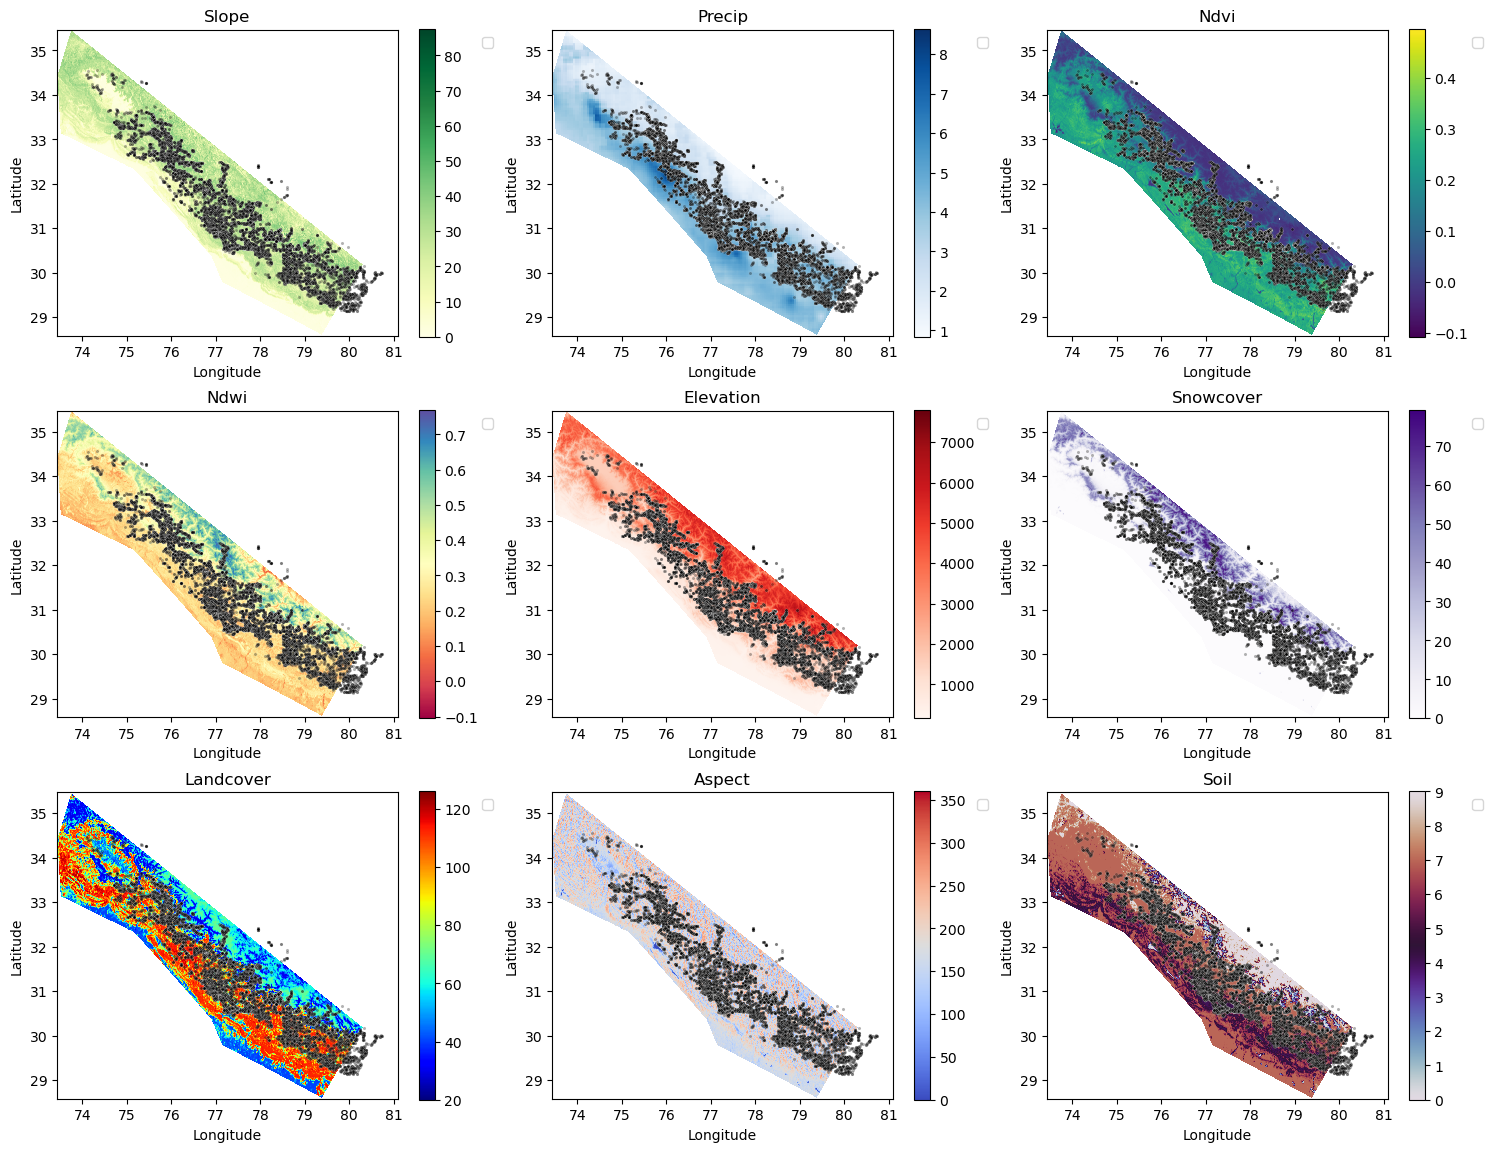

In [6]:
# plot all satellite bands
cmaps = ['YlGn', 'Blues', 'viridis', 'Spectral', 'Reds', 'Purples', 'jet', 'coolwarm', 'twilight', 'Reds']

# Plotting all rasters and landslide occurrences
plt.figure(figsize = (15, 15))

for i, band in enumerate(all_bands.keys()):
    with rio.open('updatedRasters/'+band+'.tif') as src:
        feat = src.read(1) # read feature raster
        transform = src.transform
        crs = src.crs
    x, y = rio.transform.xy(transform, range(feat.shape[0]), range(feat.shape[1])) # transform coordinates from array to lat/long
    x = np.array(x)
    y = np.array(y)
    plt.subplot(4,3, i+1) 
    plt.imshow(all_bands[band], cmap = cmaps[i], extent = [x.min(), x.max(), y.min(), y.max()]) # plot rasters
    plt.colorbar()
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    sns.scatterplot(x = 'longitude', y = 'latitude', s = 5, data = data, color = 'k', alpha = 0.3) # plot landslides
    plt.legend(bbox_to_anchor = (1.3,1))
    plt.title(band.capitalize())
plt.tight_layout()

In [7]:
all_bands_df = {}
for band in bands:
    all_bands[band] = all_bands[band][:, :8559] # reshape all bands to similar size
    all_bands_df[band] = all_bands[band].ravel() # flatten all bands

all_bands_df = pd.DataFrame(all_bands_df).dropna().reset_index(drop=True) # dataframe of band values at all point

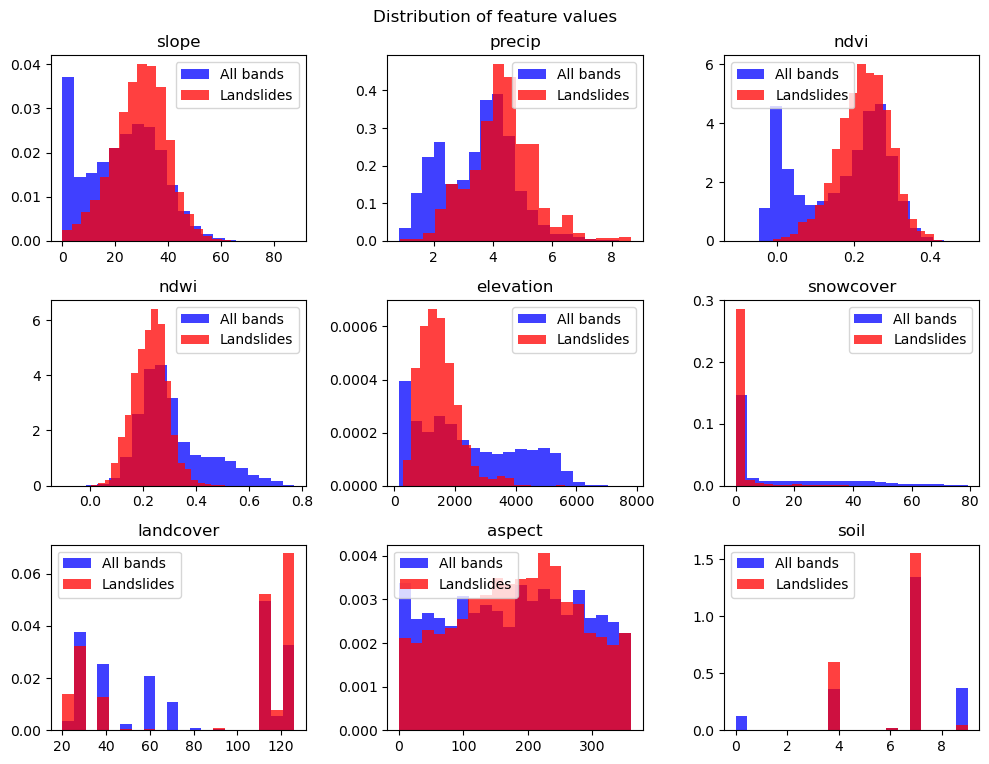

In [8]:
# Create histograms of each band

plt.figure(figsize = (10,10))
for i, f in enumerate(features):
    plt.subplot(4,3,i+1)
    plt.hist(all_bands_df[f], color = 'blue', label = 'All bands', alpha = 0.75, density = True, bins = 20)
    plt.hist(data[f], color = 'r', label = 'Landslides', alpha = 0.75, density = True, bins = 20)
    plt.legend()
    plt.title(f)
plt.suptitle('Distribution of feature values')
plt.tight_layout()

In [109]:
# conditions for weak negative labels
conditions = (all_bands['slope'] < 15) & (all_bands['precip'] < 4) & (all_bands['ndwi'] > 0.3)  & (all_bands['ndvi'] < 0.2) 

In [112]:
# dataframe of no landslides
negative = all_bands_df[(all_bands_df.slope < 15) & (all_bands_df.precip < 4) & (all_bands_df.ndwi > 0.3) &(all_bands_df.ndvi < 0.2)].reset_index(drop=True)
negative['landslide'] = np.zeros(len(negative))
negative = negative.dropna()

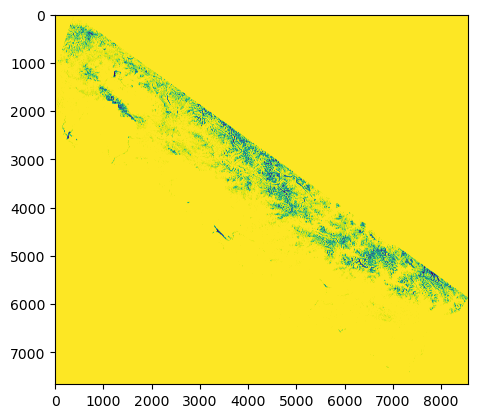

In [113]:
# Visualize no landslide regions
plt.imshow(np.where(conditions, 0, 1))

In [114]:
data['landslide'] = np.ones(len(data))
training = data.iloc[:,3:].append(negative.sample(frac = 0.1)).sample(frac = 1).reset_index(drop=True)

/var/folders/9v/gbghw4697p5219tnn983g81w0000gn/T/ipykernel_63963/4163967152.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  training = data.iloc[:,3:].append(negative.sample(frac = 0.1)).sample(frac = 1).reset_index(drop=True)


In [9]:
# import required sklearn classes
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [117]:
X = training.iloc[:,:-1].to_numpy()
y = training.iloc[:, -1].to_numpy()

In [118]:
# train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [119]:
# logistic regression fitting
log_reg = LogisticRegression().fit(X_train, y_train)

/opt/anaconda3/envs/cee263c/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [120]:
# Stack all rasters to a feature tensor
feature_tensor = np.stack([all_bands[b] for b in bands], axis = -1)
feature_tensor.shape

(7664, 8559, 9)

In [121]:
# Landslide susceptiability at each array element
feature_tensor = feature_tensor.reshape(-1, 9)
st = time.time()
sus = [np.nan if np.isnan(feature_tensor[i,:]).sum() > 0 else log_reg.predict_proba(feature_tensor[i,:].reshape(1,9))[0][1] for i in range(len(feature_tensor))]
et = time.time()
print(f'Time Taken to predict on full dataset: {((et-st)/60):.1f} minutes')

Time Taken to predict on full dataset: 22.3 minutes


In [24]:
# Save landslide susceptibility array as tiff file
landsus = np.load('landslide_susceptibility.npy')
res = 0.0008983152841195216455
xmin = x.min()
ymax = y.max()
transform = rio.transform.from_origin(xmin, ymax, res, res)
crs = rio.crs.CRS.from_epsg(4326)
with rio.open('landsus.tif', 'w', driver='GTiff', height=landsus.shape[0], width=landsus.shape[1], count=1, dtype=landsus.dtype, crs=crs, transform=transform) as dst:
    dst.write(landsus, 1)

<AxesSubplot:title={'center':'Landslide Susceptibility Map'}, xlabel='Longitude', ylabel='Latitude'>

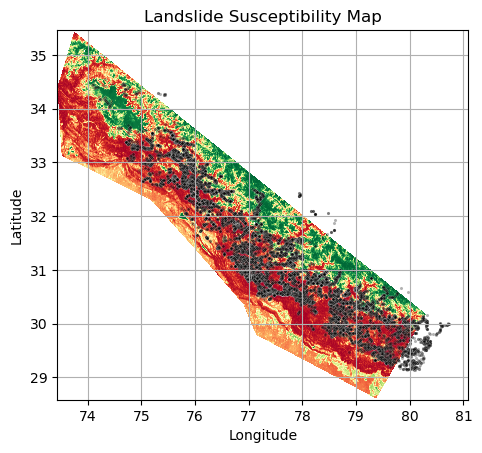

In [50]:
# plot landslide susceptibility 
plt.imshow(landsus, extent = [x.min(), x.max(), y.min(), y.max()], cmap = 'RdYlGn_r')
plt.grid()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Landslide Susceptibility Map')
sns.scatterplot(x = 'longitude', y = 'latitude', data = data, c='k', s = 5, alpha = 0.3)